## Create Multi-Layer NN model using tensorflow

So I can adjust the parameters as I want...

In [16]:
import sys
sys.path.append("./src") # append to system path

from sklearn import cross_validation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.patches import Rectangle
style.use('ggplot')



In [17]:
def load_lcia_data(descs_p, target_p):
    X = pd.read_csv(descs_p,header=0,index_col=None)
    X = X.fillna(X.mean())
    y = pd.read_csv(target_p,header=0,index_col=None)
    return X.values,y.values

def mre(true_y,pred_y):
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((true_y - pred_y) / true_y)) * 100

### Load data
from csv

In [18]:
descs_p = './data/descs/descs_Mar08_166_3839.csv'
target_p = './data/target/CED.csv'
X,y = load_lcia_data(descs_p, target_p)

trn_X, tst_X, trn_y, tst_y = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=1)

In [19]:
print trn_X.shape, trn_y.shape

(132, 3839) (132, 1)


### Data Preprocessing
Normalization + PCA or Just Normalization

### Just Scaler

In [20]:
## Standard Scaler
this_scaler = StandardScaler()
trn_X = this_scaler.fit_transform(trn_X)
tst_X = this_scaler.transform(tst_X)

In [21]:
print trn_X
print trn_X.shape

[[-1.62569245 -0.82660826 -1.4890865  ...,  0.         -0.18698007
  -0.21821789]
 [-0.53138493 -0.06405605 -0.84172575 ...,  0.         -0.18698007
  -0.21821789]
 [-0.6942586  -0.80394144 -0.04137544 ...,  0.         -0.18698007
  -0.21821789]
 ..., 
 [ 1.84400373  2.39461662 -0.68114993 ...,  0.         -0.18698007
  -0.21821789]
 [-0.62897636 -0.58708431 -0.39476866 ...,  0.         -0.18698007
  -0.21821789]
 [ 0.52353195 -0.54496464  1.20245492 ...,  0.         -0.18698007
  -0.21821789]]
(132, 3839)


##  PCA

In [22]:
### PCA, don't run them together
# normalize the data first
pca = PCA(n_components = 30)

trn_X = pca.fit_transform(trn_X)
tst_X = pca.transform(tst_X)

In [23]:
print trn_X
print trn_X.shape
print(reduce(lambda x,y:x+y,pca.explained_variance_ratio_))

[[-53.59895013  13.20745816 -18.84214267 ...,  -0.07463057  -2.67591603
    2.72993315]
 [-25.23395823   4.46858383  -3.33329015 ...,  -2.50557708  -0.27664144
    0.70961515]
 [-10.60457048  -1.68856812   4.95363973 ...,  -1.25382252   1.21326993
   -3.70298066]
 ..., 
 [-25.59362413   3.59385286  -5.7531404  ...,   7.63432539  -0.96228743
    2.39360353]
 [-11.71478168   1.85059549   1.09457285 ...,  -0.76431811   2.3721897
    1.08945557]
 [ 26.86476941   4.87049461 -10.71316391 ...,  -2.04130259  -4.5130164
    2.45125673]]
(132, 30)
0.871119102318


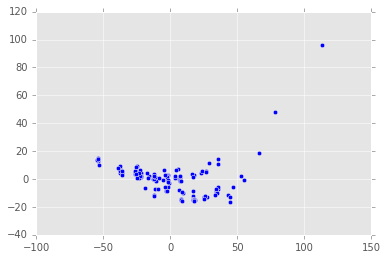

In [24]:
plt.scatter(trn_X[:,0],trn_X[:,1])
plt.show()

### Build the model

In [29]:
def init_weights(shape):
    weights = tf.random_normal(shape,stddev = 0.1)
    return tf.Variable(weights)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

num_descs = trn_X.shape[1]
num_target = trn_y.shape[1]

print num_descs,num_target

30 1


In [30]:
##### 
##Define model structure

X = tf.placeholder(tf.float32,shape=[None,num_descs])
y = tf.placeholder(tf.float32,shape=[None,num_target])

#First layer
w1 = init_weights((num_descs,128)) 
b1 = bias_variable([128])
l1 = tf.add(tf.matmul(X,w1),b1)
l1 = tf.nn.sigmoid(l1)

# Second layer
w2 = init_weights((128,128))
b2 = bias_variable([128])
l2 = tf.add(tf.matmul(l1,w2),b2)
l2 = tf.nn.sigmoid(l2)

# # Third layer
# w3 = init_weights((128,128))
# b3 = bias_variable([128])
# l3 = tf.add(tf.matmul(l2,w3),b3)
# l3 = tf.nn.sigmoid(l3)

#Output layer
w_out = init_weights((128,num_target))
b_out = bias_variable([num_target])
l_out = tf.matmul(l2,w_out) + b_out #no nonlinarity

pred = l_out

In [32]:
#static parameters
BATCH_SIZE = 1
BETA = 0.1 #regularization weights

#Define loss and optimizer 
#Add regularization term
# regularizers = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3) + tf.nn.l2_loss(w_out)
regularizers = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w_out)
cost = tf.reduce_mean(tf.square(pred - y) + BETA*regularizers)

#Gridient Descent Optimizer
optimizer = tf.train.AdagradOptimizer(learning_rate = 0.005).minimize(cost)


# Initializing the variables
init = tf.global_variables_initializer()

## Training

In [ ]:
#Start Training
costs=[]

#save the model
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(2000):
        for i in range(0, len(trn_X),BATCH_SIZE):
            _, c = sess.run([optimizer,cost], feed_dict={X:trn_X[i:i+BATCH_SIZE], y:trn_y[i:i+BATCH_SIZE]})
        
        trn_score = r2_score(trn_y,sess.run(pred, feed_dict={X:trn_X, y:trn_y}))
        tst_score = r2_score(tst_y,sess.run(pred, feed_dict={X:tst_X, y:tst_y}))     
        tst_mre = mre(tst_y,sess.run(pred,feed_dict={X:tst_X,y:tst_y}))
        
        costs.append(tst_score)
        if epoch % 100 == 0:
            print("Epoch = %d,Cost = %.2f,Training Accuracy = %.2f, Testing Accuracy = %.2f, Testing MRE =%.2f" % (epoch + 1,c,trn_score,tst_score,tst_mre))
    
    final_pred = sess.run(pred,feed_dict={X:tst_X,y:tst_y})
    final_pred_trn = sess.run(pred,feed_dict={X:trn_X,y:trn_y})
    
    for (y,y_hat) in zip(tst_y,final_pred):
                print y,y_hat
    
    
    plt.plot(costs)
    plt.show()
    
    save_path = saver.save(sess, "./nets/tmp/tmp.ckpt")
    print("Model saved in file: %s" % save_path)

Epoch = 1,Cost = 8651.34,Training Accuracy = -4.04, Testing Accuracy = -2.29, Testing MRE =80.56
Epoch = 101,Cost = 586.03,Training Accuracy = 0.14, Testing Accuracy = -0.03, Testing MRE =33.27
Epoch = 201,Cost = 125.57,Training Accuracy = 0.39, Testing Accuracy = -0.01, Testing MRE =40.91
Epoch = 301,Cost = 37.21,Training Accuracy = 0.46, Testing Accuracy = 0.01, Testing MRE =40.94
Epoch = 401,Cost = 35.00,Training Accuracy = 0.56, Testing Accuracy = 0.06, Testing MRE =38.75
Epoch = 501,Cost = 27.21,Training Accuracy = 0.61, Testing Accuracy = 0.08, Testing MRE =39.27
Epoch = 601,Cost = 23.93,Training Accuracy = 0.64, Testing Accuracy = 0.09, Testing MRE =39.65
Epoch = 701,Cost = 24.84,Training Accuracy = 0.66, Testing Accuracy = 0.11, Testing MRE =39.46
Epoch = 801,Cost = 27.00,Training Accuracy = 0.69, Testing Accuracy = 0.13, Testing MRE =38.61
Epoch = 901,Cost = 24.95,Training Accuracy = 0.72, Testing Accuracy = 0.15, Testing MRE =38.55
Epoch = 1001,Cost = 25.04,Training Accuracy 

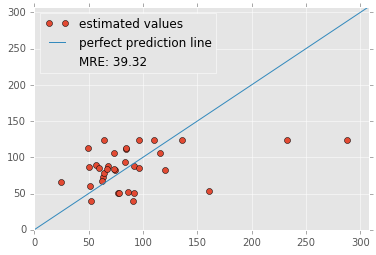

In [15]:

MRE_this = mre(tst_y, final_pred)
MRE_label = 'MRE: ' + str(round(MRE_this,2))

fig = plt.figure()
ax = fig.add_subplot(111)
est = plt.plot(tst_y, final_pred,'o', label='estimated values')


max_val = max(max(tst_y),max(final_pred))
plt.ylim([0,max_val+20])
plt.xlim([0,max_val+20])

thisLine = plt.plot(np.append(0,max_val+20), np.append(0,max_val+20), label='perfect prediction line')

plt.plot([],[],linewidth=0, label=MRE_label)
plt.legend(loc='upper left')
plt.show()